In [1]:
from plantcv import plantcv as pcv

In [3]:
class options:
    def __init__(self):
        self.image = "C:/Users/Beth/Downloads/00-00-00.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "./multi_plant_tutorial_results"
        self.outdir = "." # Store the output to the current directory 

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug


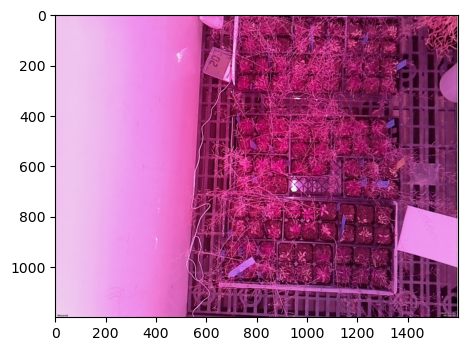

In [4]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

In [5]:
import numpy as np

In [6]:
# Check if this is a night image, for some of these dataset's images were captured
# at night, even if nothing is visible. To make sure that images are not taken at
# night we check that the image isn't mostly dark (0=black, 255=white).
# if it is a night image it throws a fatal error and stops the workflow.

if np.average(img) < 50:
    pcv.fatal_error("Night Image")
else:
    pass

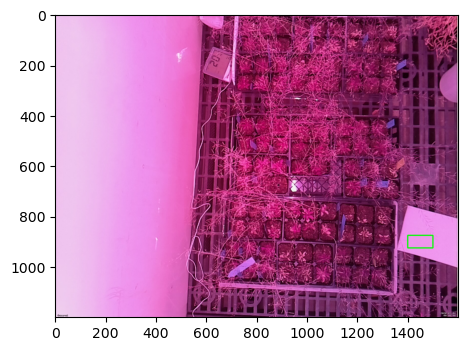

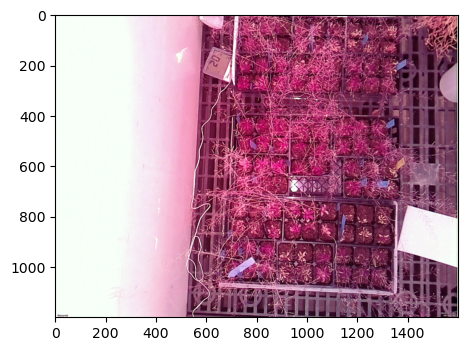

In [27]:
# Normalize the white color so you can later
# compare color between images.

# Inputs:
#   img = image object, RGB color space
#   roi = region for white reference, if none uses the whole image,
#         otherwise (x position, y position, box width, box height)

# white balance image based on white toughspot
img1 = pcv.white_balance(img, roi=(1400,875,100,50))


In [28]:
#Optional Rotate 
# Rotate the image slightly so the plants line up with 
# the grid that we'll add in a later step

# Inputs:
#   img = image object, RGB color space
#   rotation_deg = Rotation angle in degrees, can be negative, positive values 
#                  will move counter-clockwise 
#   crop = If True then image will be cropped to orginal image dimensions, if False
#          the image size will be adjusted to accommodate new image dimensions 
##rotate_img = pcv.rotate(img=img1, rotation_deg=-1, crop=False)

In [29]:
#Optional Shift
#Shift image. This step is important for clustering later on.
# For this image it also allows you to push the green raspberry pi camera
# out of the image. This step might not be necessary for all images.
# The resulting image is the same size as the original.

# Inputs:
#   img    = image object
#   number = integer, number of pixels to move image
#   side   = direction to move from "top", "bottom", "right","left"
##shift1 = pcv.shift_img(img=img1, number=40, side='top')
##img1 = shift1


In [22]:
#Optional Flip
#Optionally, one could use the `pcv.flip` function that flips an image in either the 
# horizontal or vertical direction

# Inputs:
#   img   = RGB or grayscale image data 
#   direction = The direction you want the image flipped, either 'horizontal' or 'vertical' 
##flipped_img = pcv.flip(img=img, direction='vertical')

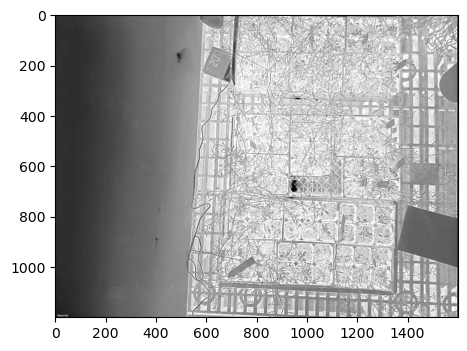

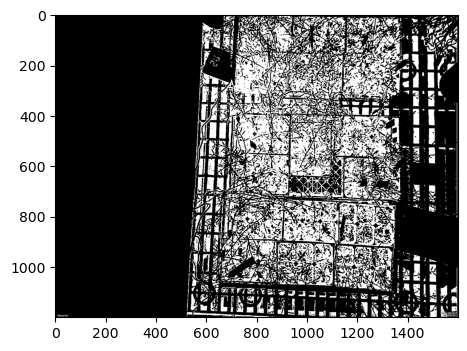

In [44]:
# Convert image from RGB color space to LAB color space
# Keep only the green-magenta channel (grayscale)

# Inputs:
#    rgb_img = image object, RGB color space
#    channel = color subchannel ('l' = lightness, 'a' = green-magenta , 'b' = blue-yellow)
a = pcv.rgb2gray_lab(rgb_img=img1, channel='a')


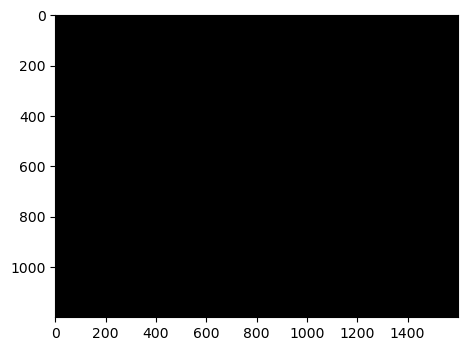

In [41]:
# Set a binary threshold on the saturation channel image

# Inputs:
#    gray_img    = img object, grayscale
#    threshold   = threshold value (0-255)
#    max_value   = value to apply above threshold (usually 255 = white)
#    object_type = light or dark
#       - If object is light then standard thresholding is done
#       - If object is dark then inverse thresholding is done
img_binary = pcv.threshold.binary(gray_img=a, threshold=0, max_value=800, object_type='dark')
#                                                        ^
#                                                        |
#                                         adjust this value

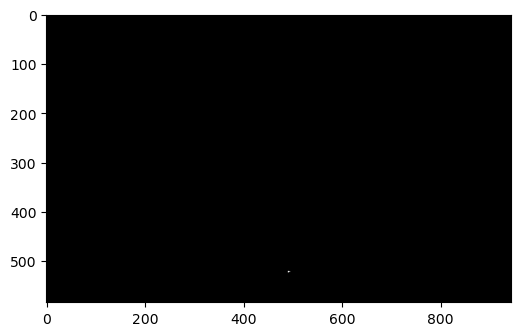

In [42]:
# Fill in small objects (speckles)

# Inputs:
#    bin_img  = binary image. img will be returned after filling
#    size     = minimum object area size in pixels (integer)
fill_image = pcv.fill(bin_img=img_binary, size=10)
#                                                ^
#                                                |
#                                 adjust this value


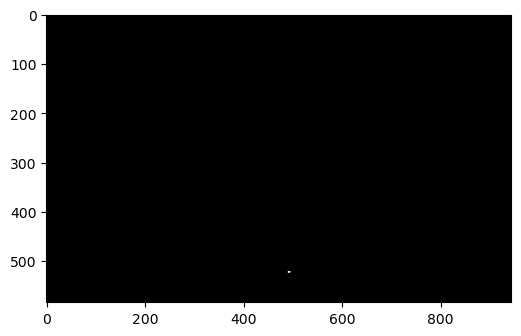

In [43]:
# Dilate so that you don't lose leaves (just in case)

# Inputs:
#    gray_img = input image
#    ksize    = integer, kernel size
#    i        = iterations, i.e. number of consecutive filtering passes
dilated = pcv.dilate(gray_img=fill_image, ksize=2, i=1)


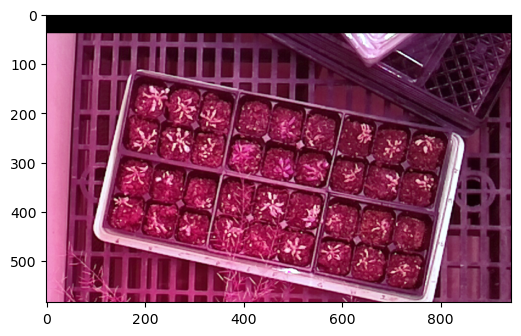

In [44]:
# Find objects (contours: black-white boundaries)

# Inputs:
#    img  = image that the objects will be overlayed
#    mask = what is used for object detection
id_objects, obj_hierarchy = pcv.find_objects(img=img1, mask=dilated)


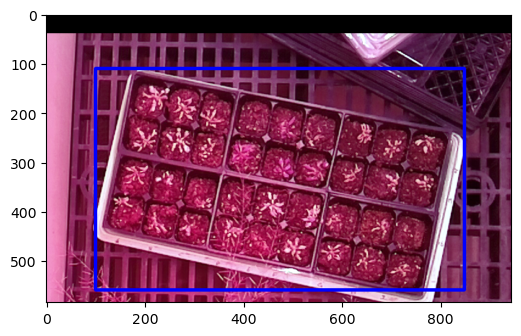

In [53]:
# Define region of interest (ROI)

# Inputs:
#    img   = An RGB or grayscale image to plot the ROI on.
#    x     = The x-coordinate of the upper left corner of the rectangle.
#    y     = The y-coordinate of the upper left corner of the rectangle.
#    h     = The width of the rectangle.
#    w     = The height of the rectangle.
#   roi_contour, roi_hierarchy = pcv.roi.rectangle(5, 90, 200, 390, img1) 
#                                                  |______________|
#                                            adjust these four values
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img1, x=100, y=110, h=450, w=750)


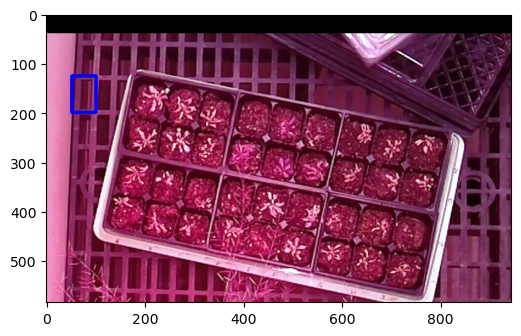

In [60]:
# (Optional): Get the size of the marker. First make a region of interest around one of 
# the toughspots. Then use `report_size_marker_area`. 
marker_contour, marker_hierarchy = pcv.roi.rectangle(img=img1, x=52, y=125, h=75, w=50)



In [63]:
# Inputs:
#   img - RGB or grayscale image to plot the marker object on 
#   roi_contour = A region of interest contour 
#   roi_hierarchy = A region of interest contour heirarchy 
#   marker = 'define' (default) or 'detect', if 'define' then you set an area, if 'detect'
#            it means you want to detect within an area 
#   objcolor = Object color is 'dark' (default) or 'light', is the marker darker or lighter than 
#               the background?
#   thresh_channel = 'h', 's', 'v' for hue, saturation, or value. Default set to None. 
#   thresh = Binary threshold value (integer), default set to None 
analysis_images = pcv.report_size_marker_area(img=img1, roi_contour=marker_contour, 
                                              roi_hierarchy=marker_hierarchy, marker='detect', 
                                              objcolor='dark', thresh_channel='v', thresh=230)


In [64]:
# Keep objects that overlap with the ROI

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)
roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img1, roi_contour=roi_contour, 
                                                                      roi_hierarchy=roi_hierarchy,
                                                                      object_contour=id_objects, 
                                                                      obj_hierarchy=obj_hierarchy, 
                                                                      roi_type='partial')


In [65]:
# Check if all of the plants fall completely within the bounds of an image 
# or if it touches the edge. Used for QC. 

# Inputs:
#   mask = Binary mask 
in_bounds = pcv.within_frame(mask=kept_mask)


In [66]:
# This function take a image with multiple contours and
# clusters them based on user input of rows and columns

# Inputs:
#    img               = An RGB or grayscale image
#    roi_objects       = object contours in an image that are needed to be clustered.
#    roi_obj_hierarchy = object hierarchy
#    nrow              = number of rows to cluster (this should be the approximate  number of 
#                        desired rows in the entire image even if there isn't a literal row of plants)
#    ncol              = number of columns to cluster (this should be the approximate number of 
#                        desired columns in the entire image even if there isn't a literal row of plants)
#    show_grid         = if True then the grid is drawn on the image, default show_grid=False
clusters_i, contours, hierarchies = pcv.cluster_contours(img=img1, roi_objects=roi_objects, 
                                                         roi_obj_hierarchy=roi_obj_hierarchy, 
                                                         nrow=4, ncol=6, 
                                                         show_grid=True)


In [67]:
# OPTIONAL: For debugging or for making figures 

# The image is relatively small, decrease the global line thickness parameter 
pcv.params.line_thickness = 2

# Plot to visualize what pieces of plant got grouped together.

# Inputs:
#   img - RGB or grayscale image data for plotting
#   grouped_contour_indices - Indices for grouping contours
#   roi_objects - object contours in an image that are needed to be clustered.
#   roi_obj_hierarchy - object hierarchy
#   nrow - Optional, number of rows. If changed from default, grid gets plot. 
#   ncol - Optional, number of columns. If changed from default, grid gets plot. 
cluster_img = pcv.visualize.clustered_contours(img=img1, grouped_contour_indices=clusters_i, 
                                                roi_objects=contours,
                                                roi_obj_hierarchy=hierarchies)


In [68]:
# The pcv.cluster_contours function uses another PlantCV function
# that returns a random list of RGB color values equally spaces
# across a rainbow color spectrum. This function can be useful 
# when a color palette is needed 

# Inputs:
#   num - An integer greater than or equal to 1. If num=1 then 
#         a random color is returned 
rand_colors = pcv.color_palette(num=5)
print(rand_colors)


[(0, 0, 255), (0, 255, 205), (100, 255, 0), (255, 106, 0), (255, 0, 199)]


In [69]:
# This function takes clustered contours and splits them into multiple images,
# also does a check to make sure that the number of inputted filenames matches the number
# of clustered contours. If no filenames are given then the objects are just numbered

# Inputs:
#    img                     = ideally a masked RGB image.
#    grouped_contour_indexes = output of cluster_contours, indexes of clusters of contours
#    contours                = contours to cluster, output of cluster_contours
#    hierarchy               = object hierarchy
#    outdir                  = directory for output images
#    file                    = the name of the input image to use as a base name , output of filename from read_image function
#    filenames               = input txt file with list of filenames in order from top to bottom left to right (likely list of genotypes)

# Set global debug behavior to None (default), "print" (to file), or "plot" (Jupyter Notebooks or X11)
# Un-comment the line below to see the split up contours print to the output directory 
#pcv.params.debug = "print"

out = args.outdir

# If you have a list of treatments, genotypes, etc. You would input a .txt file with them to help save
# the contours by names, add it to the options class and then add filenames=names to the 
# splitimg function below.  
output_path = pcv.cluster_contour_splitimg(rgb_img=img1, grouped_contour_indexes=clusters_i, contours=contours, 
                                           hierarchy=hierarchies, outdir=out, file=filename, filenames=None)


This function has been updated to include object hierarchy so object holes can be included


In [71]:
# Read in one of the isolated plant images 
single_plant, plant_path, plant_filename = pcv.readimage(filename='./20-00-00_zoom.jpg')


RuntimeError: Failed to open ./20-00-00_zoom.jpg